# Investigating COVID-19 Transmission in Supermarkets
By: Rebecca Flach and Daniel Quinteros

The following code replicates the research conducted in [**Modeling COVID-19 transmission in supermarkets using an agent-based model**](https://www.semanticscholar.org/reader/17a2627fca7585df99f9d214831992a3756ed772) by Fabian Ying, Neave O’Clery.

In [1]:
!pip install covid19-supermarket-abm

In [2]:
from covid19_supermarket_abm.utils.load_example_data import load_example_store_graph
from covid19_supermarket_abm.utils.create_synthetic_baskets import get_all_shortest_path_dicts
from covid19_supermarket_abm.path_generators import get_path_generator
from covid19_supermarket_abm.simulator import simulate_several_days
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

### Default Store Simulations

Create and visualize the dining hall network where the simulations will occur

In [31]:
# Load store network data
G = load_example_store_graph()

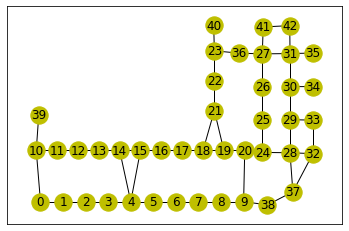

In [32]:
# Draw store network
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos, node_color='y')

Create a path generator which feeds our model with customer paths

In [33]:
entrance_nodes = [39, 40, 41]
till_nodes = [33, 34, 35]
exit_nodes = [42]
item_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
              19, 20, 21, 22, 23,24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38]
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(G)
synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

Simulate the store operations under the default configuration parameters

In [39]:
# Set parameters
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Simulate several days and store results in default_sim_results
num_days = 1000
default_sim_results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 1000/1000 [09:02<00:00,  1.84it/s]


Calculate the average number of daily infections based on the mean total exposure time

In [40]:
transmission_rate = 1.41 * pow(10, -9)
default_infections = (default_sim_results[0]['total_exposure_time'].mean()) * transmission_rate

print("Mean Total Exposure Time: ", default_sim_results[0]['total_exposure_time'].mean(), 
      "\nAverage # of Daily Infections: ", default_infections)

Mean Total Exposure Time:  5.854109354059973 
Average # of Daily Infections:  8.254294189224561e-09


### Store Network Heatmap Visualization

Based on mean exposure time in each zone. The color ranges from black to bright red. The brighter the red, the higher the average exposure time is in that zone.

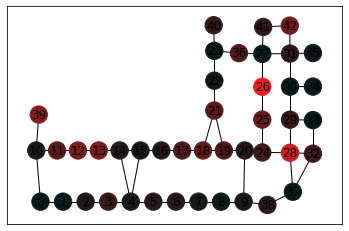

In [107]:
exposures = default_sim_results[2].mean(0)
nx.draw_networkx(G, pos=pos, node_color=[((exposure-min(exposures))/(max(exposures)-min(exposures)), 0.1, 0.1) for exposure in exposures])

## Covid Exposure Interventions

### Restricting Maximum Number of Customers in Store

Perform a parameter sweep, varying the maximum store capacity from 1 to 30 customers.

In [132]:
rate_results = []

config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
           'max_customers_in_store_per_sqm': 0,  # Maximum number of customers per sqm (per zone) 
           'floorarea': 100  # Floor area (1 sqm per zone)
          #  'max_customers_in_store' = max_customers_in_store_per_sqm * floorarea
         }


transmission_rate = 1.41 * pow(10, -9)
rates = np.linspace(0.01, 0.3, 30)
for rate in rates:
    config['max_customers_in_store_per_sqm'] = rate
    results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=1000,
                                    use_parallel=False)
    rate_results.append((results[0]['total_exposure_time'].mean()) * transmission_rate)

100%|██████████| 1000/1000 [07:20<00:00,  2.27it/s]


Text(0.5, 1.0, 'Infections v. Max. Capacity')

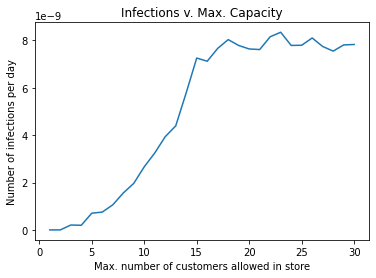

In [133]:
plt.plot(rates * config['floorarea'], rate_results)
plt.xlabel('Max. number of customers allowed in store')
plt.ylabel('Number of infections per day')
plt.title('Infections v. Max. Capacity')

### Varying Customer Arrival Rate

Perform a parameter sweep, varying the rate at which customers enter the store from 0 to 2.5 customers/min.

In [21]:
arrival_rate_infections = []

config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }


transmission_rate = 1.41 * pow(10, -9)
arrival_rates = np.linspace(0.1, 2.5, 25)
for rate in arrival_rates:
    config['arrival_rate'] = rate
    arrival_rate_sim_results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=1000,
                                    use_parallel=False)
    arrival_rate_infections.append((arrival_rate_sim_results[0]['total_exposure_time'].mean()) * transmission_rate)

100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


Text(0.5, 1.0, 'Infections v. Customer Arrival Rate')

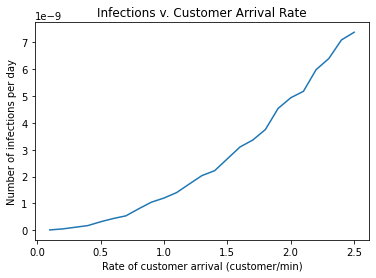

In [22]:
plt.plot(arrival_rates, arrival_rate_infections)
plt.xlabel('Rate of customer arrival (customer/min)')
plt.ylabel('Number of infections per day')
plt.title('Infections v. Customer Arrival Rate')

### Face Masks

Implementation of a fask mask policy via a reduction in the transmission rate.

In [150]:
# Set parameters
rrr = 0.17  # Relative transmission risk reduction

config = {'arrival_rate': 2.55 * rrr,  # Poisson rate at which customers arrive * rrr
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Simulate several days and store results in results
num_days = 1000
face_mask_sim_results = simulate_several_days(config, G, path_generator_function, path_generator_args, num_iterations=num_days,
                                use_parallel=False)

100%|██████████| 1000/1000 [01:14<00:00, 13.45it/s]


In [151]:
transmission_rate = 1.41 * pow(10, -9)
face_mask_infections = (face_mask_sim_results[0]['total_exposure_time'].mean()) * transmission_rate

print("Mean Total Exposure Time: ", face_mask_sim_results[0]['total_exposure_time'].mean(), 
      "\nAverage # of Daily Infections: ", face_mask_infections)

(0.16035078818656148, 2.260946113430517e-10)

### One-way Aisle Layout

Change store graph to a directed graph, where some edges are uni-directional. 

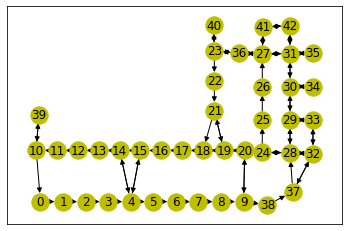

In [27]:
# Load store network data
G_oneway = load_example_store_graph(directed=True)

# Draw store network
pos = nx.get_node_attributes(G_oneway, 'pos')
nx.draw_networkx(G_oneway, pos=pos, node_color='y')

Create a path generator which feeds our model with student paths

In [28]:
entrance_nodes = [39, 40, 41]
till_nodes = [33, 34, 35]
exit_nodes = [42]
item_nodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
              19, 20, 21, 22, 23,24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38]
mu = 0.07
sigma = 0.76
shortest_path_dict = get_all_shortest_path_dicts(G_oneway)
synthetic_path_generator_args = [mu, sigma, entrance_nodes, till_nodes, exit_nodes, item_nodes, shortest_path_dict]
path_generator_function, path_generator_args = get_path_generator(path_generation='synthetic',
                                                           synthetic_path_generator_args=synthetic_path_generator_args)

Simulate the one-way store operations under the default configuration parameters

In [29]:
config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 10,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }

# Simulate several days and store results in oneway_sim_results
num_days = 1000
oneway_sim_results = simulate_several_days(config, G_oneway, path_generator_function, path_generator_args, num_iterations=num_days)

100%|██████████| 1000/1000 [06:50<00:00,  2.43it/s]


Calculate the average number of daily infections based on the mean total exposure time

In [30]:
transmission_rate = 1.41 * pow(10, -9)
oneway_infections = (oneway_sim_results[0]['total_exposure_time'].mean()) * transmission_rate

print("Mean Total Exposure Time: ", oneway_sim_results[0]['total_exposure_time'].mean(), "minutes"
      "\nAverage # of Daily Infections: ", oneway_infections)

Mean Total Exposure Time:  5.2449811518252805 minutes
Average # of Daily Infections:  7.395423424073646e-09


#### One Way Aisle Layout + Rate of Customer Arrival

In [8]:
one_way_arrival_rate_results = []

config = {'arrival_rate': 2.55,  # Poisson rate at which customers arrive
           'traversal_time': 0.2,  # mean wait time per node
           'num_hours_open': 14,  # store opening hours
           'infection_proportion': 0.0011,  # proportion of customers that are infectious
         }


transmission_rate = 1.41 * pow(10, -9)
arrival_rates = np.linspace(0.1, 2.5, 25)
for rate in arrival_rates:
    config['arrival_rate'] = rate
    results = simulate_several_days(config, G_oneway, path_generator_function, path_generator_args, num_iterations=1000,
                                    use_parallel=False)
    one_way_arrival_rate_results.append((results[0]['total_exposure_time'].mean()) * transmission_rate)

100%|██████████| 1000/1000 [10:20<00:00,  1.61it/s]


Text(0.5, 1.0, 'Infections v. Customer Arrival Rate')

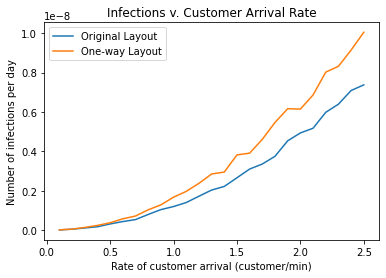

In [26]:
plt.plot(arrival_rates, arrival_rate_infections)
plt.plot(arrival_rates, one_way_arrival_rate_results)
plt.legend(['Original Layout', 'One-way Layout'])
plt.xlabel('Rate of customer arrival (customer/min)')
plt.ylabel('Number of infections per day')
plt.title('Infections v. Customer Arrival Rate')